# Predicting weather as a time series
## One model per cluster per feature

In [1]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D

In [2]:
cluster_df = pd.read_csv('../output_clusters/agroclimatic_clusters.csv')

In [3]:
cluster_df.head()

,Year,Month,ppt(mm),tmax(degC),tmin(degC),aet(mm),PDSI(unitless),state,district,cluster14,cluster15,cluster18,cluster20,cluster25,cluster27,cluster30,cluster35
0,1958,1,0,32.1,16.6,2,-0.1,maharashtra,solapur,8,7,0,7,12,23,15,23
1,1958,2,0,34.2,18.4,2,-0.5,maharashtra,solapur,8,7,0,7,12,23,15,23
2,1958,3,17,38.5,21.5,17,0.2,maharashtra,solapur,8,7,0,7,12,23,15,23
3,1958,4,32,40.2,25.3,32,0.8,maharashtra,solapur,8,7,0,7,12,23,15,23
4,1958,5,68,40.5,25.8,65,1.5,maharashtra,solapur,8,7,0,7,12,23,15,23


## Continuous-Continous Bivariate Analysis

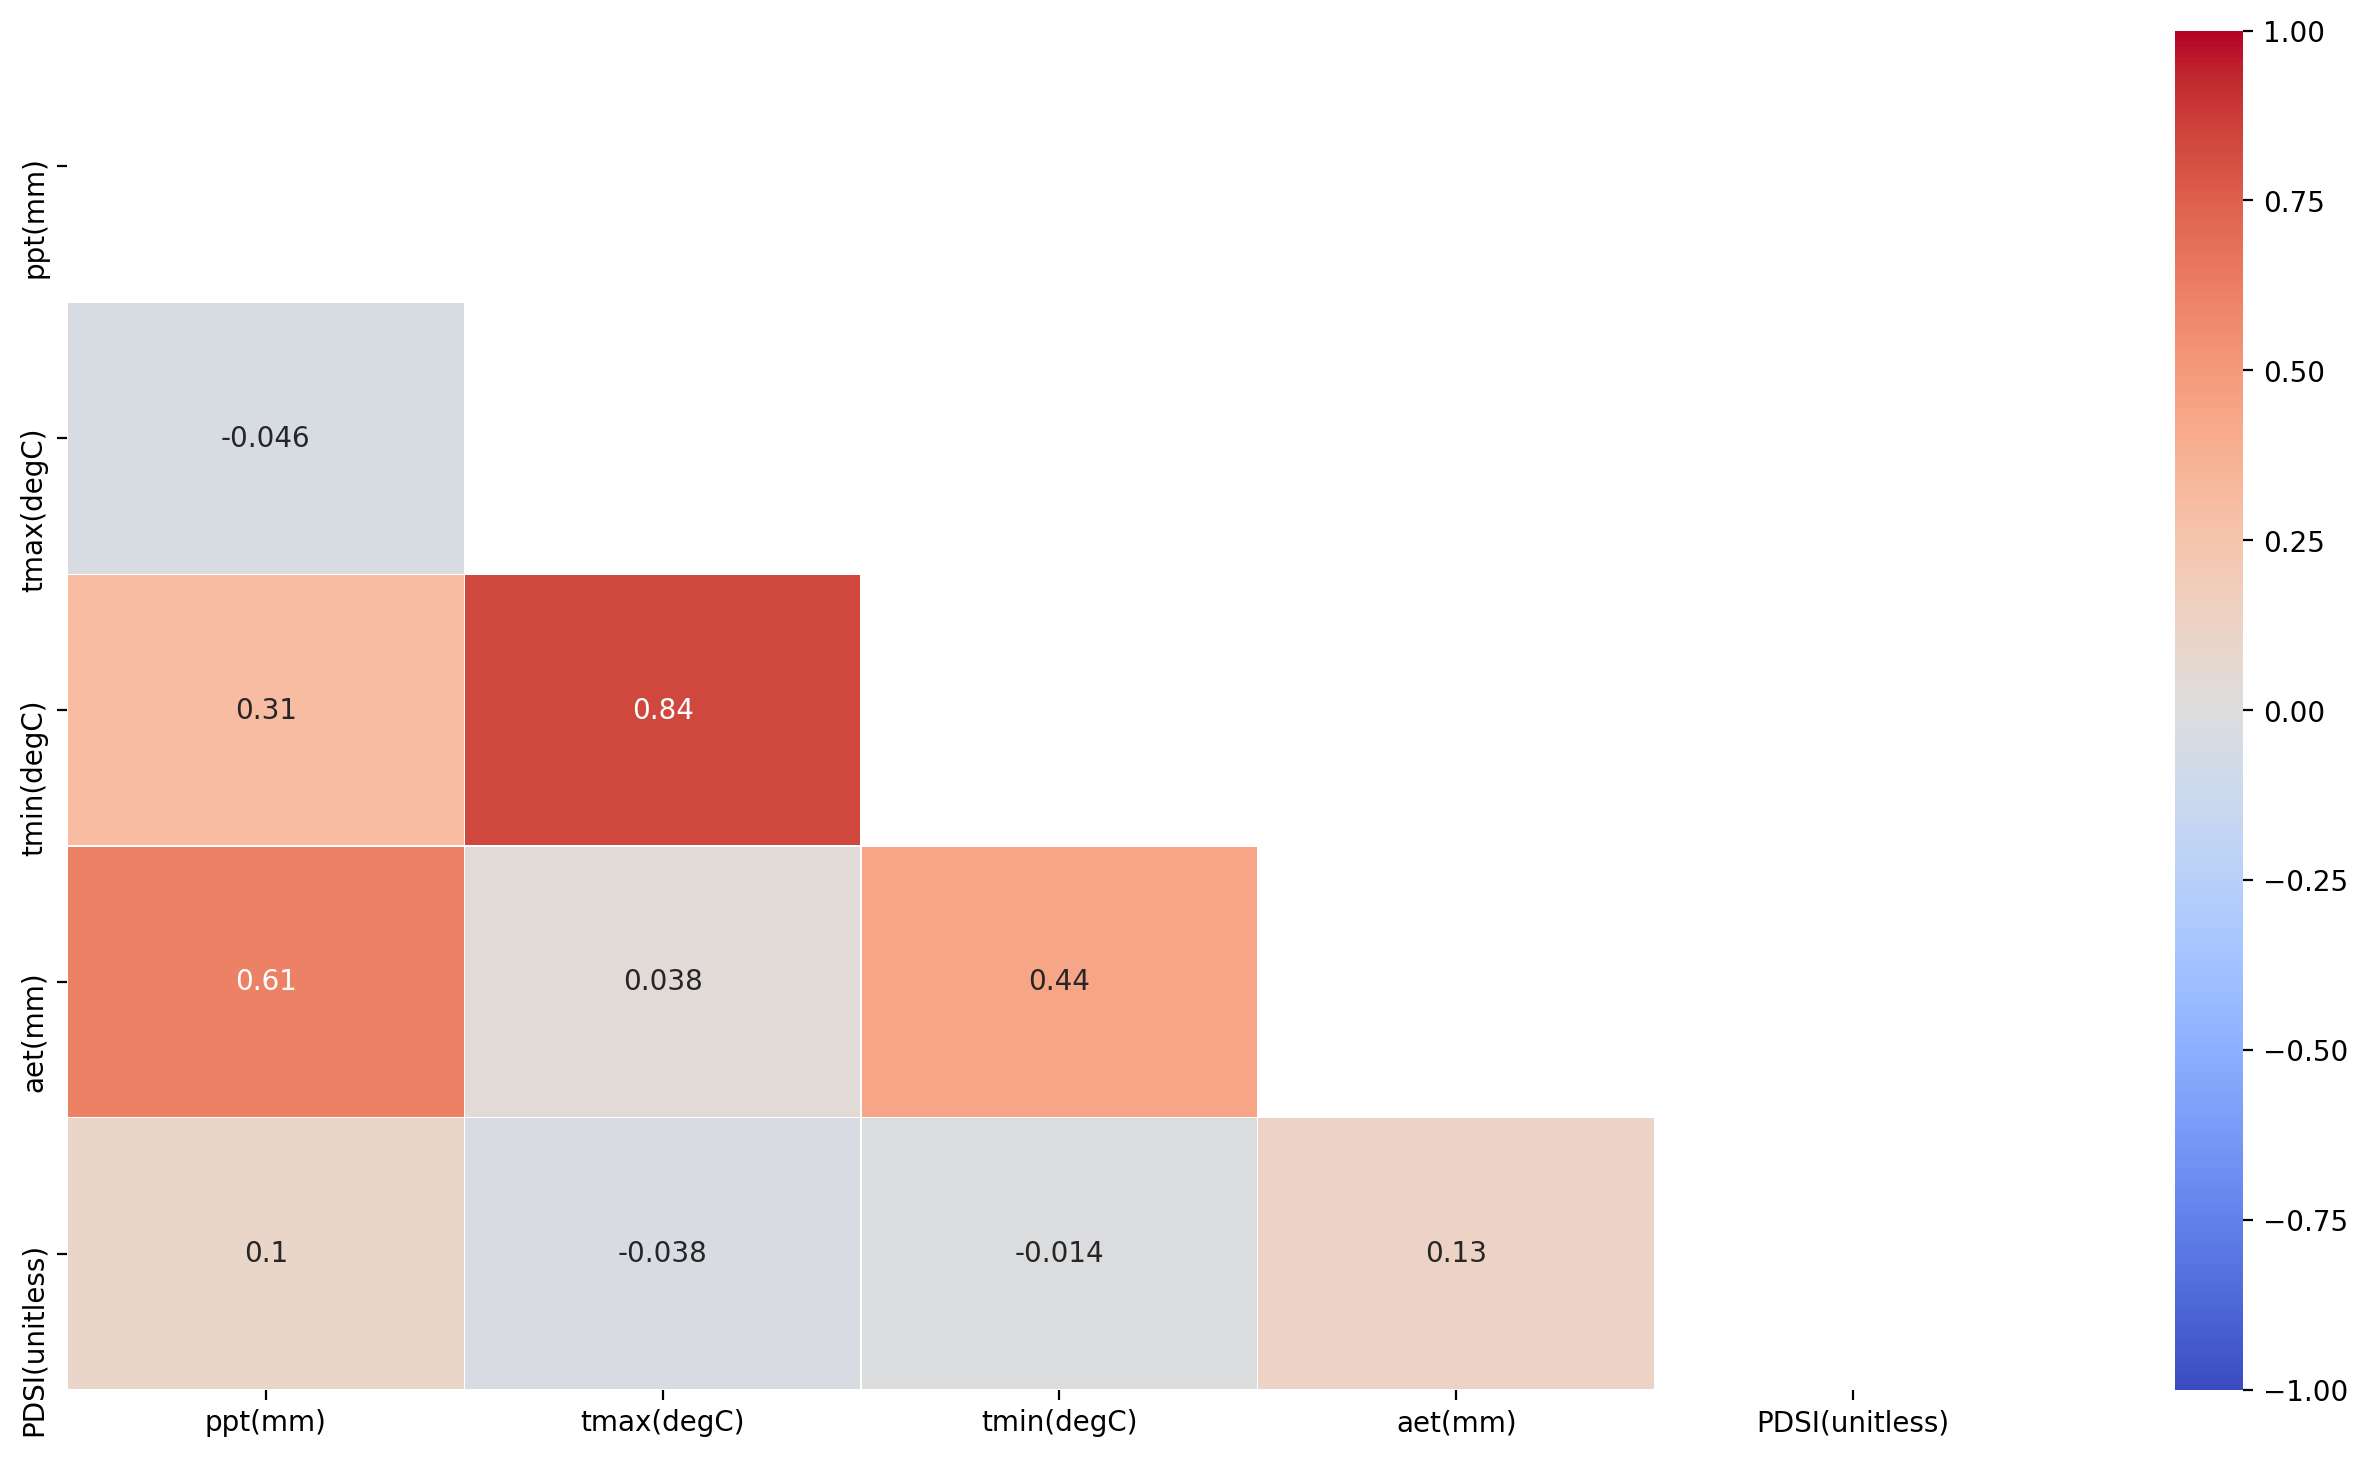

In [4]:
plt.figure(figsize=(16, 9), dpi=200)
corr_plot = cluster_df[['ppt(mm)', 'tmax(degC)', 'tmin(degC)', 'aet(mm)',
                        'PDSI(unitless)']].corr()
mask = np.zeros_like(corr_plot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_plot,
            square=False,
            linewidth=.1,
            vmin=-1,
            vmax=1,
            cmap='coolwarm',
            annot=True,
            mask=mask)
plt.show()

## Timeseries Prediction

### Basic Trial

<AxesSubplot:>

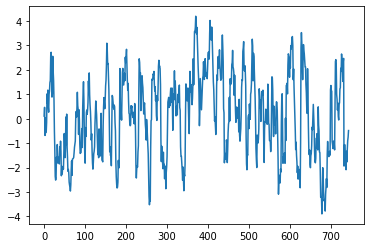

In [5]:
cluster_df.loc[(cluster_df.cluster14 == 0)].groupby(['Year', 'Month'])[
    'PDSI(unitless)'].mean().reset_index(drop=True).plot()

In [6]:
# split into train and test sets
dataset = cluster_df.loc[(cluster_df.cluster14 == 0)].groupby(['Year', 'Month'])[
    'PDSI(unitless)'].mean().reset_index()
train_size = int(dataset.shape[0] * 0.67)
test_size = len(dataset) - train_size
train, test = dataset.iloc[0:train_size, :], dataset.iloc[train_size:dataset.shape[0], :]
print(len(train), len(test))

498 246


In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset.loc[i:(i+look_back), 'PDSI(unitless)']
        dataX.append(a)
        dataY.append(dataset.loc[i + look_back, 'PDSI(unitless)'])
    return np.array(dataX), np.array(dataY)

In [8]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [9]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(trainX.shape[1:])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
# batch_size = 1
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
496/496 - 1s - loss: 0.0251
Epoch 2/50
496/496 - 1s - loss: 0.0201
Epoch 3/50
496/496 - 1s - loss: 0.0165
Epoch 4/50
496/496 - 1s - loss: 0.0134
Epoch 5/50
496/496 - 1s - loss: 0.0103
Epoch 6/50
496/496 - 1s - loss: 0.0080
Epoch 7/50
496/496 - 2s - loss: 0.0062
Epoch 8/50
496/496 - 2s - loss: 0.0046
Epoch 9/50
496/496 - 2s - loss: 0.0037
Epoch 10/50
496/496 - 1s - loss: 0.0031
Epoch 11/50
496/496 - 1s - loss: 0.0025
Epoch 12/50
496/496 - 1s - loss: 0.0022
Epoch 13/50
496/496 - 1s - loss: 0.0019
Epoch 14/50
496/496 - 1s - loss: 0.0018
Epoch 15/50
496/496 - 2s - loss: 0.0016
Epoch 16/50
496/496 - 1s - loss: 0.0014
Epoch 17/50
496/496 - 1s - loss: 0.0012
Epoch 18/50
496/496 - 2s - loss: 0.0013
Epoch 19/50
496/496 - 2s - loss: 0.0013
Epoch 20/50
496/496 - 2s - loss: 0.0013
Epoch 21/50
496/496 - 2s - loss: 0.0011
Epoch 22/50
496/496 - 2s - loss: 8.6814e-04
Epoch 23/50
496/496 - 1s - loss: 9.4783e-04
Epoch 24/50
496/496 - 1s - loss: 8.4477e-04
Epoch 25/50
496/496 - 1s - loss: 7.23

In [19]:
# make predictions using first model
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.03 RMSE


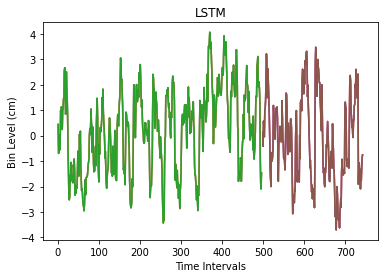

In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('Time Intervals')
plt.ylabel('Bin Level (cm)')
plt.title('LSTM')
plt.show()